# *CoastSat.islands*: example at Eva Island, Australia

This toolkit extends the main [CoastSat toolbox](https://github.com/kvos/CoastSat) and enables users to measure shoreline position and two-dimensional planform characteristics (area and orientation) at small sandy islands from satellite imagery. 

Detailed methodology and application to a set of islands is described in: 
* Cuttler MVW, Vos K, Branson P, Hansen JE, O'Leary M, Browne NK, Lowe RJ (2020) Reef island response to climate-driven variations in water level and wave climate (under review)

The underlying CoastSat software is described in:
* Vos K., Splinter K.D., Harley M.D., Simmons J.A., Turner I.L. (2019). CoastSat: a Google Earth Engine-enabled Python toolkit to extract shorelines from publicly available satellite imagery. Environmental Modelling and Software. 122, 104528. https://doi.org/10.1016/j.envsoft.2019.104528

## Initial settings

Refer to the [Installation](https://github.com/kvos/CoastSat) section of the CoastSat README for instructions on how to install the Python packages necessary to run the software, including Google Earth Engine Python API. If that step has been completed correctly, the following packages should be imported without any problem.

In [1]:
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from coastsat import SDS_islands, SDS_download, SDS_preprocess, SDS_tools, SDS_transects

C:\Users\Kilian\.conda\envs\coastsat\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## 1. Retrieval of the images from GEE

Define the region of interest (`polygon`), the date range (`dates`) and the satellite missions (`sat_list`) from which you wish to retrieve the satellite images. The images will be cropped on the Google Earth Engine server and only the region of interest will be downloaded as a .tif file. The files will stored in the directory defined in `filepath`. 

Make sure the area of your ROI is smaller than 100 km2 (if larger split it into smaller ROIs).

The function `SDS_download.check_images_available(inputs)` will print the number of images available for your inputs. The Landsat images are divided in Tier 1 and Tier 2, only Tier 1 images can be used for time-series analysis. 

In [2]:
# region of interest (longitude, latitude in WGS84), can be loaded from a .kml polygon
polygon = SDS_tools.polygon_from_kml(os.path.join(os.getcwd(), 'example','EVA.kml'))
# or enter the coordinates (first and last pair of coordinates are the same)
# polygon = [[114.4249504953477, -21.9295184484435],
#            [114.4383556651795, -21.92949300318377],
#            [114.4388731500701, -21.91491228133647],
#            [114.4250081185656, -21.91495393621703],
#            [114.4249504953477, -21.9295184484435]]

# date range
dates = ['2019-01-01', '2019-02-01']
# satellite missions
sat_list = ['S2']
# name of the site
sitename = 'EVA'
# directory where the data will be stored
filepath = os.path.join(os.getcwd(), 'data')
# put all the inputs into a dictionnary
inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'sitename': sitename, 'filepath':filepath}

# before downloading the images, check how many images are available for your inputs
SDS_download.check_images_available(inputs);

Images available between 2019-01-01 and 2019-02-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
  S2: 24 images
  Total: 24 images


The function `SDS_download.retrieve_images(inputs)` retrives the satellite images from Google Earth Engine.

By default, only Landsat Tier 1 and Sentinel-2 Level-1C are downloaded. 

In case you need to access Tier 2 images for qualitative analysis, you need to set `inputs['include_T2'] = True` before calling `retrieve_images`.

In [ ]:
# inputs['include_T2'] = True
metadata = SDS_download.retrieve_images(inputs)

**If you have already retrieved the images**, just load the metadata file by only running the section below

In [3]:
metadata = SDS_download.get_metadata(inputs) 

## 2. Map island contours

This section maps the island contour on each satellite image. 
The user can define the cloud threhold (`cloud_thresh`) and select the spatial reference system in which to output the coordinates of the mapped contours (`output_epsg`). See http://spatialreference.org/ to find the EPSG number corresponding to your local coordinate system. Make sure that your are using cartesian coordinates and not spherical coordinates (lat,lon) like WGS84. If unsure, use 3857 which is the web mercator projection (used by Google Maps). 

To quality control each shoreline detection and manually validate the mapped shorelines, the user has the option to set the parameter `check_detection_sand_poly` to **True**. To save a figure for each mapped shoreline set `save_figure` to **True**. 

The other parameters are for advanced users only and are described in the README.

In [4]:
# settings for the sand contour mapping
settings = { 
    # general parameters:
    'cloud_thresh': 0.5,        # threshold on maximum cloud cover
    'output_epsg': 3857,        # epsg code of spatial reference system desired for the output
    # quality control:        
    'check_detection_sand_poly': True, # if True, uses sand polygon for detection and shows user for validation 
    'save_figure': True,               # if True, saves a figure showing the mapped shoreline for each image
    # add the inputs defined previously
    'inputs': inputs,
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 50,       # minimum area (in metres^2) for an object to be labelled as a beach
    'buffer_size': 100,         # radius (in metres) of the buffer around sandy pixels considered in the shoreline detection
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images
    'sand_color': 'default',    # 'default', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
}

### [OPTIONAL] Save .jpg of the satellite images 
Saves .jpg files of the preprocessed satellite images (cloud masking + pansharpening/down-sampling) under *./data/sitename/jpeg_files\preprocessed*

In [ ]:
SDS_preprocess.save_jpg(metadata, settings)

### [OPTIONAL] Digitize a reference shoreline
Creates a reference shoreline which helps to identify outliers and false detections. The reference shoreline is manually digitised by the user on one of the images. The parameter `max_dist_ref` defines the maximum distance from the reference shoreline (in metres) at which a valid detected shoreline can be. If you think that the default value of 100 m will not capture the full shoreline variability of your site, increase this value to an appropriate distance.

In [5]:
%matplotlib qt
settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
settings['max_dist_ref'] = 100 # max distance (in meters) allowed from the reference shoreline

Reference shoreline already exists and was loaded


### Batch contour detection
Extracts the 2D island contours from the images in the spatial reference system specified by the user in `'output_epsg'`. The mapped shorelines are saved into `output.pkl` (under *./data/sitename*) and `output.geojson` (to be used in a GIS software).

If you see that the sand pixels on the images are not being identified, change the parameter `sand_color` from `default` to `dark` or `bright` depending on the color of your beach. 

In [6]:
%matplotlib qt
output = SDS_islands.extract_sand_poly(metadata, settings)

Mapping shorelines:
S2:   100%


Simple plot of the mapped contours and time-series of island metrics. Check the structure of `output`variable to see what information is available for each contour (dates, cloud cover, georeferencing accuracy, area, centroid, perimeter, eccentricity, orientation, shorelines and island contours).

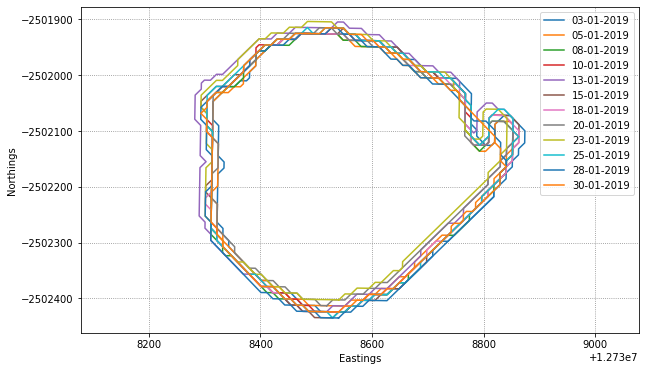

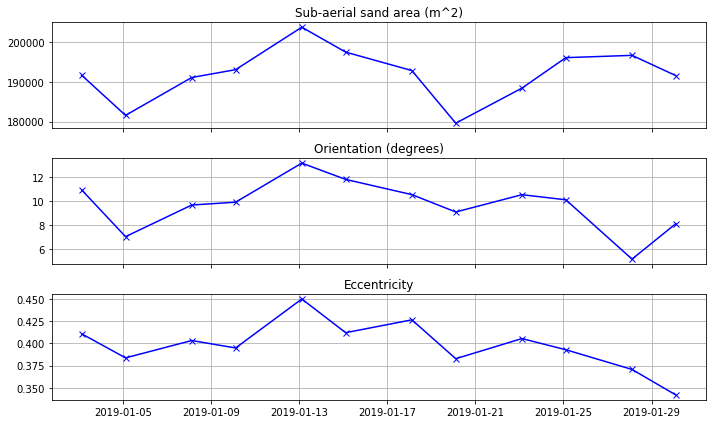

In [7]:
%matplotlib inline
# plot the sand polygons
fig = plt.figure(figsize=(10,6))
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['sand_points'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '-', label=date.strftime('%d-%m-%Y'))
plt.legend()   

# plot time-series of island metrics (area, orientation, eccentricity)
fig, ax = plt.subplots(3,1, figsize=(10,6), tight_layout=True, sharex=True)
ax[0].plot(output['dates'],output['sand_area'],'b-x')
ax[0].grid('on')
ax[0].set(title='Sub-aerial sand area (m^2)')
ax[1].plot(output['dates'],np.array(output['sand_orientation'])*180/np.pi,'b-x')
ax[1].grid('on')
ax[1].set(title='Orientation (degrees)')
ax[2].plot(output['dates'],output['sand_eccentricity'],'b-x')
ax[2].grid('on')
ax[2].set(title='Eccentricity');

## 3. Shoreline/island contour analysis

In this section we show how to compute time-series of cross-shore distance along user-defined shore-normal transects.

For circular islands there is the option to automatically generate the transects based on the centroid.

**If you have already mapped the shorelines**, just load the output file (`output.pkl`) by running the section below

In [7]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f)

To create the cross-shore transects along which to compute the intersections with the 2D shorelines, there are several options (generate them automatically, draw them manually, load from file or enter coordinates directly).

**Option 1**: Generate the cross-shore transects automatically

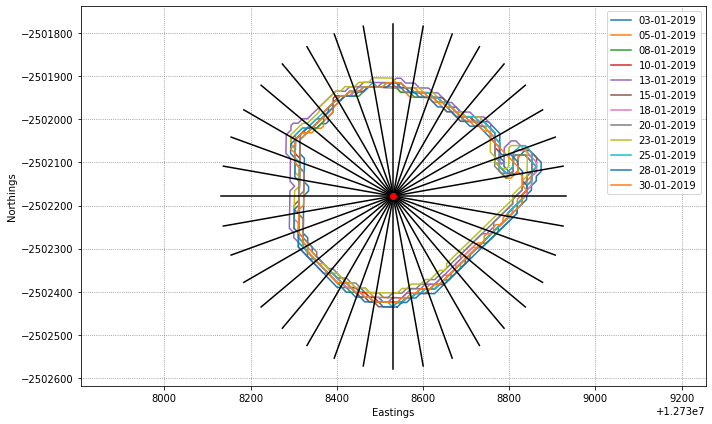

In [11]:
# angles for the transects around the island
ang_start = 0 
ang_end = 360
# degree interval for calculating transects
ang_step = 10
settings['heading'] = np.array(list(range(ang_start,ang_end,ang_step)))
# origing of all the transects
settings['island_center'] = [12738531, -2502178]
# length of each transect from the origin
settings['transect_length'] = 400
# generate transects automatically
transects = SDS_islands.calc_island_transects(settings)
    
# plot transects
%matplotlib inline
fig = plt.figure(figsize=(10,6), tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['sand_points'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '-', label=date.strftime('%d-%m-%Y'))
plt.legend()
for key in transects.keys():
    plt.plot(transects[key][:,0], transects[key][:,1], 'k-')
plt.plot(settings['island_center'][0],settings['island_center'][1],'ro')

**Option 2**: Draw transects manually (if island is not circular)

In [ ]:
%matplotlib qt
transects = SDS_transects.draw_transects(output, settings)

Now, intersect the transects with the 2D contours to obtain time-series of cross-shore distance.

The time-series of shoreline change for each transect are saved in a .csv file in the data folder (all dates are in UTC time). 

In [12]:
# defines the along-shore distance over which to consider shoreline points to compute the median intersection (robust to outliers)
settings['along_dist'] = 10
cross_distance = SDS_islands.compute_intersection_islands(output, transects, settings)        

Calculating intersections: 100%Time-series of the shoreline change along the transects saved as:
C:\Users\Kilian\Documents\GitHub\CoastSat.islands\data\EVA\transect_time_series.csv


### 4. Tidal correction

In [13]:
#load input tide data, it is in local time (Australian West Coast, UTC +8 hrs), but code below converts to UTC
tide_file = os.path.join(os.getcwd(),'example','EvaTide_2019.txt')
tide, output_corrected = SDS_islands.process_tide_data(tide_file, output)    

# define beach slope to be used for tidal correction
settings['beach_slope'] = 0.1375
# define reference height datum for tidal correction
settings['zref'] = 0      
# tidally correct the time-series of shoreline change along the transects              
cross_distance_corrected = SDS_islands.tide_correct(cross_distance,tide, output, transects, settings)
   
# also a function to tidally corrected the sand polygons     
output_corrected = SDS_islands.tide_correct_sand_polygon(cross_distance_corrected, output_corrected, settings)

Calculating tides: 100%Time-series of the shoreline change along the transects saved as:
C:\Users\Kilian\Documents\GitHub\CoastSat.islands\data\EVA\transect_time_series_corrected.csv
